In [333]:
import pyspike
from drn_interactions.spikes import SpikesHandler
from drn_interactions.load import load_neurons, load_derived_generic

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from spiketimes.df.surrogates import shuffled_isi_spiketrains_by, jitter_spiketrains_by

<AxesSubplot:xlabel='session_name'>

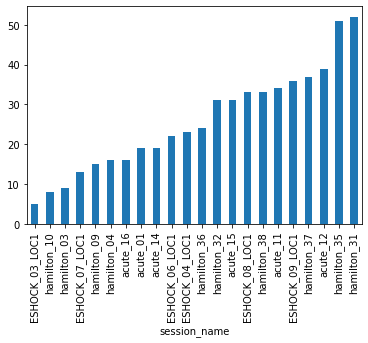

In [262]:
neurons = load_neurons()
neurons.groupby("session_name").apply(len).sort_values().plot(kind="bar")

In [334]:
t_start= 0
t_stop = t_start + 1200
session_name = "hamilton_31"
bin_width = 0.002

sh = SpikesHandler(
    block="pre", 
    bin_width=bin_width, 
    session_names=[session_name], 
    t_stop=t_stop, 
    t_start=t_start,
    )

In [363]:
df = sh.spikes
# df2 = jitter_spiketrains_by(df, by_col="neuron_id", n=1, jitter_window_size=1)
df2 = shuffled_isi_spiketrains_by(df, by_col="neuron_id", n=1)


real_spiketrains = [
    pyspike.SpikeTrain(
        df.query(f"neuron_id == {n_id}")["spiketimes"].sort_values().values,
        edges=(t_start, t_stop) 
        )
    for n_id in sh.neuron_ids
    if len(df.query(f"neuron_id == {n_id}")) > 100
]

reses = []
for i in range(50):
    fake_spiketrains = [
        pyspike.SpikeTrain(
            df2.query(f"neuron_id == {n_id}")["spiketimes"],
            edges=(t_start, t_stop) 
            )
        for n_id in df2.neuron_id.unique()
        if len(df2.query(f"neuron_id == {n_id}")) > 100
    ]
    reses.append(pyspike.spike_sync_matrix(fake_spiketrains, max_tau=0.1).ravel())

In [364]:
from drn_interactions.stats import p_adjust

In [365]:
res_real = pyspike.spike_sync_matrix(real_spiketrains)


p_vals = np.empty(res_real.shape).ravel()
reps = np.vstack(reses)

for i, val in enumerate(res_real.ravel()):
    p_vals[i] = (reps[:, i] > val).mean()

p_vals = p_adjust(p_vals).reshape(res_real.shape)


Text(0.5, 1.0, 'pvals')

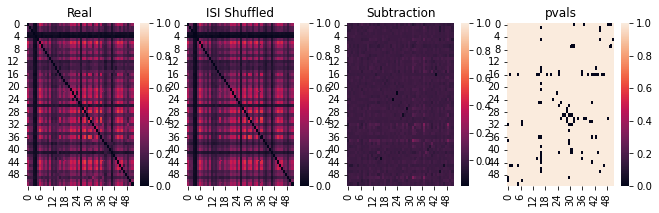

In [372]:
tau = 0.2

_, ax = plt.subplots(ncols=4, figsize=(11, 3))
res_real = pyspike.spike_sync_matrix(real_spiketrains, max_tau=0.1)
# res_fake = pyspike.spike_sync_matrix(fake_spiketrains)
res_fake = np.vstack(reses).mean(axis=0).reshape(res_real.shape)

sns.heatmap(
    res_real, ax=ax[0], 
    vmax=1
    )
ax[0].set_title("Real")


sns.heatmap(
    res_fake, ax=ax[1], 
    vmax=1
    )
ax[1].set_title("ISI Shuffled")

sns.heatmap(
    res_real - res_fake, ax=ax[2], 
    vmax=1
    )
ax[2].set_title("Subtraction")

sns.heatmap(
    p_vals < 0.05, ax=ax[3], 
    )
ax[3].set_title("pvals")

Text(0.5, 1.0, 'pvals')

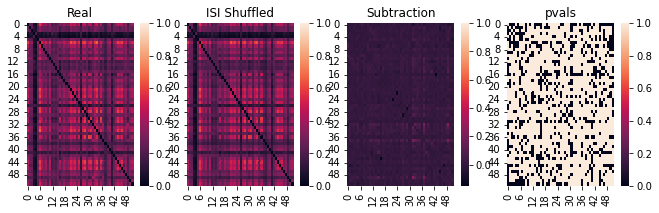

In [355]:
tau = 0.2

_, ax = plt.subplots(ncols=4, figsize=(11, 3))
res_real = pyspike.spike_sync_matrix(real_spiketrains)
# res_fake = pyspike.spike_sync_matrix(fake_spiketrains)
res_fake = np.vstack(reses).mean(axis=0).reshape(res_real.shape)

sns.heatmap(
    res_real, ax=ax[0], 
    vmax=1
    )
ax[0].set_title("Real")


sns.heatmap(
    res_fake, ax=ax[1], 
    vmax=1
    )
ax[1].set_title("ISI Shuffled")

sns.heatmap(
    res_real - res_fake, ax=ax[2], 
    vmax=1
    )
ax[2].set_title("Subtraction")

sns.heatmap(
    p_vals < 0.05, ax=ax[3], 
    )
ax[3].set_title("pvals")




<AxesSubplot:>

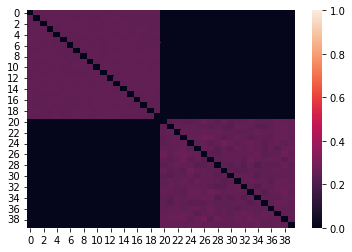

In [386]:
M = 20
spike_trains = [pyspike.generate_poisson_spikes(1000.0, [0, 100]) for m in range(M)]
spike_trains2 = [pyspike.generate_poisson_spikes(10.0, [0, 100]) for m in range(M)]


res = pyspike.spike_sync_matrix(spike_trains + spike_trains2)

sns.heatmap(
    res, 
    vmax=1
    )